# Miniproyecto 2 - Modelos de Variable Latente para el Reconocimiento de Emociones

**Autores:**  
* Jackeline Morales Hernandez

* Jose David Ortiz Miranda

**Tratamiento de Señales III**

**Facultad de Ingeniería**

**Universidad de Antioquia**



In [1]:
## Librerias importantes
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import KernelPCA
from ipywidgets import interact


1.Para el sistema de Análisis Multivariado de Señales fisiológicas obtenido en el Primer Mini-Proyecto, se debe
construir un módulo de variable latente utilizando el algoritmo de PCA. La idea es proyectar la matriz característica
obtenida $X \in \mathbb{R}^{N \times D}$, a un espacio latente de menor dimensión $q << D$, de tal forma que los nuevos datos en este
espacio sean $Z \in \mathbb{R}^{N \times q}$. Seleccione diferentes configuraciones del número de componentes q y evalúe el mejor
desempeño arrojado por el modelo midiendo el accuracy y la matriz de confusión. Para ello:



a) Realice la visualización de las componentes en el espacio latente para diferentes configuraciones de q

In [2]:
dataframe=pd.read_pickle("./dataframe_minip1.pkl")
ultima_columna = dataframe.iloc[:, -1]
ultima_columna = ultima_columna.values.reshape(-1, 1) #etiqueta
data=dataframe.values[:,0:-1]
Y=ultima_columna
scaler = StandardScaler()
data_normalizada = scaler.fit_transform(data)
X=data_normalizada
target=dataframe['Emocion']
unique_labels, counts = np.unique(Y, return_counts=True)

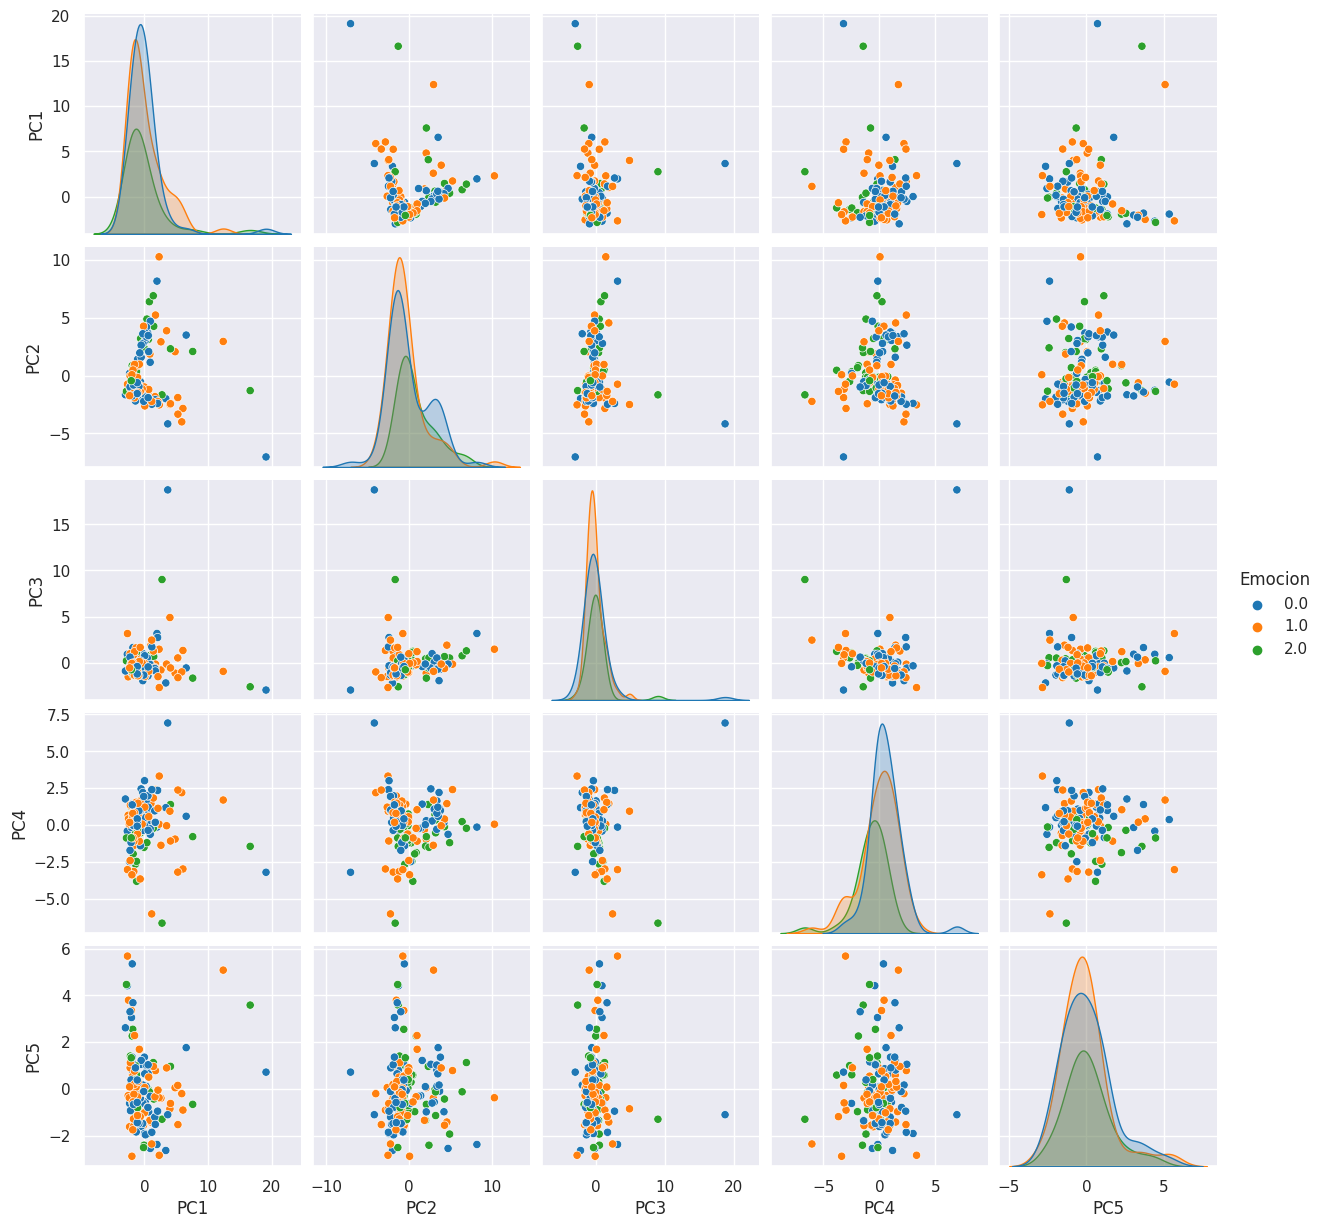

In [3]:
pca1 = PCA(n_components = 5)  # project from 64 to 2 dimensions

projectedZ1 = pca1.fit_transform(X)
X_prueba = projectedZ1[:,:5]
y = ultima_columna

#dataFrame = pd.DataFrame(X_prueba,columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10'])
dataFrame = pd.DataFrame(X_prueba,columns=['PC1','PC2','PC3','PC4','PC5'])
dataFrame['Emocion'] = y
sns.pairplot(dataFrame, hue='Emocion', palette='tab10')

- Entrene un modelo lineal de clasificacion Mínimos Cuadrados, Bayesiano y Regresión Logística, con el
fin de evaluar el desempeño en el reconocimiento de los tipos de movimiento tanto en el espacio de entrada
(sin utilizar PCA), cómo en el espacio latente.

In [4]:
def modelos(X,Y):

  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
  y_train = y_train.ravel()
  y_test = y_test.ravel()
  # ---------------- Regresión Logística ----------------------------------------------------------
  #clf = LogisticRegression(penalty='l2', random_state=0, C=1,max_iter=16000).fit(X_train, y_train)
  clf = LogisticRegression().fit(X_train, y_train)
  y_pred_LR_train = clf.predict(X_train)
  y_pred_LR_test = clf.predict(X_test)
  accTest_LR = accuracy_score(y_test, y_pred_LR_test)
  print('Accuracy para regresión logística: ', accTest_LR)
  cMat_test_LR = confusion_matrix(y_test, y_pred_LR_test)

  # ---------------- Modelo Bayesiano ----------------------------------
  gnb = GaussianNB()
  y_pred_NB = gnb.fit(X_train, y_train).predict(X_test)
  y_pred_train_NB = gnb.fit(X_train, y_train).predict(X_train)
  accTest_NB = accuracy_score(y_test, y_pred_NB)
  print('Accuracy para modelo bayesiano: ', accTest_NB)
  cMat_test_NB = confusion_matrix(y_test, y_pred_NB)

  #----------------------------Minimos cuadrados -----------------------------------
  T1 = np.tile([1.,0.,0.],(62,1))
  T2 = np.tile([0.,1.,0.],(62,1))
  T3 = np.tile([0.,0.,1.],(36,1))
  T = np.concatenate((T1,T2,T3),axis = 0)
  X_train, X_test, y_train, y_test = train_test_split(X, T, test_size=0.3, random_state=0)
  Y_train=np.argmax(y_train, axis=1)
  Y_test=np.argmax(y_test, axis=1)
  # Como el modelo compacto tiene Xtilde, debemos concatenar un vector 1s en la primer columna
  Xtilde_train = np.concatenate((np.ones((len(X_train), 1)), X_train), axis=1)
  Xtilde_test = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)

  XtildeT_train = Xtilde_train.T

  # Calcular el modelo que tiene wk_tilde por cada columna relacionada a una clase
  Wtilde = np.linalg.inv(XtildeT_train @ Xtilde_train) @ (XtildeT_train @ y_train)

  # Predicciones de entrenamiento
  Y_est_train = Xtilde_train @ Wtilde

  # Predicciones de prueba
  Xtilde_test = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
  Y_est_test = Xtilde_test @ Wtilde

  # Obtener las etiquetas predichas
  y_pred_train = np.argmax(Y_est_train, axis=1)
  y_pred_test = np.argmax(Y_est_test, axis=1)

  # Calcular la exactitud
  accTest_mi = accuracy_score(Y_test, y_pred_test)
  print('Accuracy para minimos cuadrados: ', accTest_mi)
  cMat_test_cu = confusion_matrix(Y_test,y_pred_test)


  return cMat_test_LR,cMat_test_NB,cMat_test_cu,accTest_LR,accTest_NB,accTest_mi

In [5]:
def graficar(cMat_test_LR,cMat_test_NB,cMat_test_cu ):
  emociones_uniques = target.unique()
  # Dividir los datos en conjuntos de entrenamiento y prueba
  fig, axes = plt.subplots(1,3, figsize=(18, 5))
  # Matriz de confusión para Regresión Logística
  ax1 = axes[0]
  disp_LR = ConfusionMatrixDisplay(cMat_test_LR, display_labels=emociones_uniques)
  disp_LR.plot(ax=ax1)
  ax1.set_title("Matriz de confusión regresión logística")
  ax1.grid(False)

  # Matriz de confusión para Modelo Bayesiano
  ax2 = axes[1]
  disp_NB = ConfusionMatrixDisplay(cMat_test_NB, display_labels=emociones_uniques)
  disp_NB.plot(ax=ax2)
  ax2.set_title("Matriz de confusión modelo bayesiano")
  ax2.grid(False)

  # Matriz de confusión para minimos cuadrados
  ax3 = axes[2]
  disp_cu = ConfusionMatrixDisplay(cMat_test_cu, display_labels=emociones_uniques)
  disp_cu.plot(ax=ax3)
  ax3.set_title("Matriz de confusión minimos cuadrados")
  ax3.grid(False)
  plt.show()

## **Sin usar PCA**

Accuracy para regresión logística:  0.5416666666666666
Accuracy para modelo bayesiano:  0.3958333333333333
Accuracy para minimos cuadrados:  0.8125


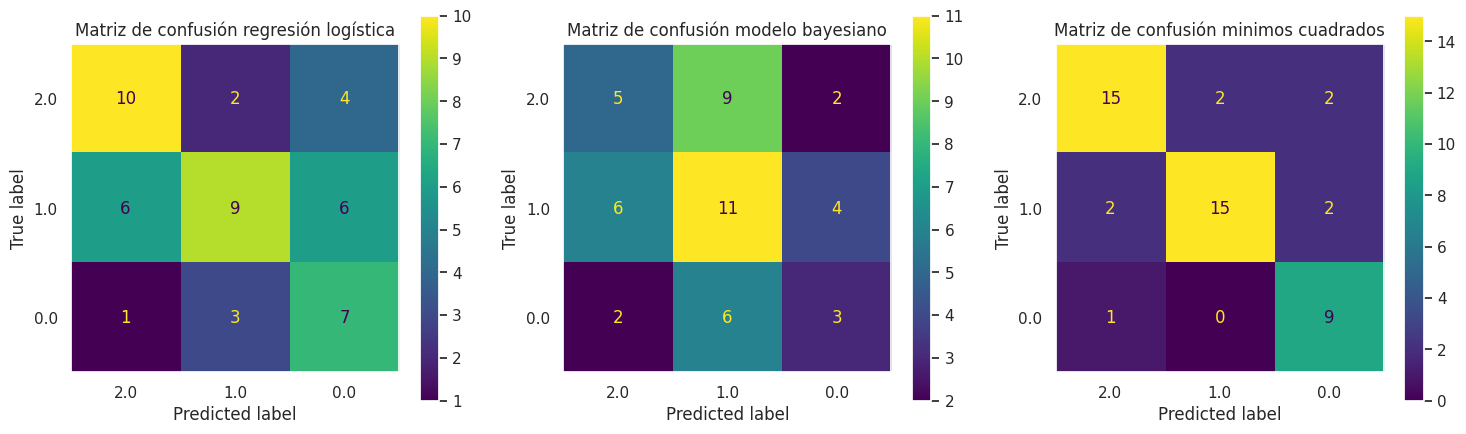

In [6]:
cMat_test_LR,cMat_test_NB,cMat_test_cu,accTest_NB,accTest_NB,accTest_mi = modelos(X,Y)
graficar(cMat_test_LR,cMat_test_NB,cMat_test_cu)

##  **Usando PCA**



### 10 componentes

Accuracy para regresión logística:  0.4375
Accuracy para modelo bayesiano:  0.4166666666666667
Accuracy para minimos cuadrados:  0.6666666666666666


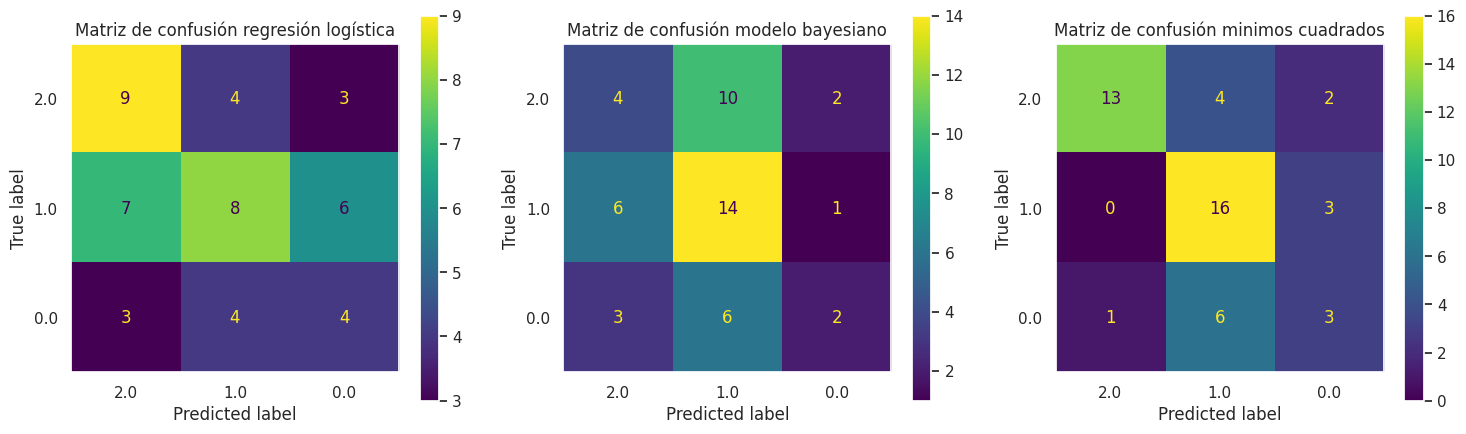

In [7]:
pca = PCA(n_components = 10)  # project from 64 to 2 dimensions
projectedZ = pca.fit_transform(X)
cMat_test_LR,cMat_test_NB,cMat_test_cu,accTest_LR,accTest_NB,accTest_mi = modelos(projectedZ,Y)
graficar(cMat_test_LR,cMat_test_NB,cMat_test_cu)
acc_LR=[]
acc_NB=[]
acc_mi=[]
acc_LR.append(accTest_LR)
acc_NB.append(accTest_NB)
acc_mi.append(accTest_mi)

### 20 componentes

Accuracy para regresión logística:  0.5625
Accuracy para modelo bayesiano:  0.4583333333333333
Accuracy para minimos cuadrados:  0.8125


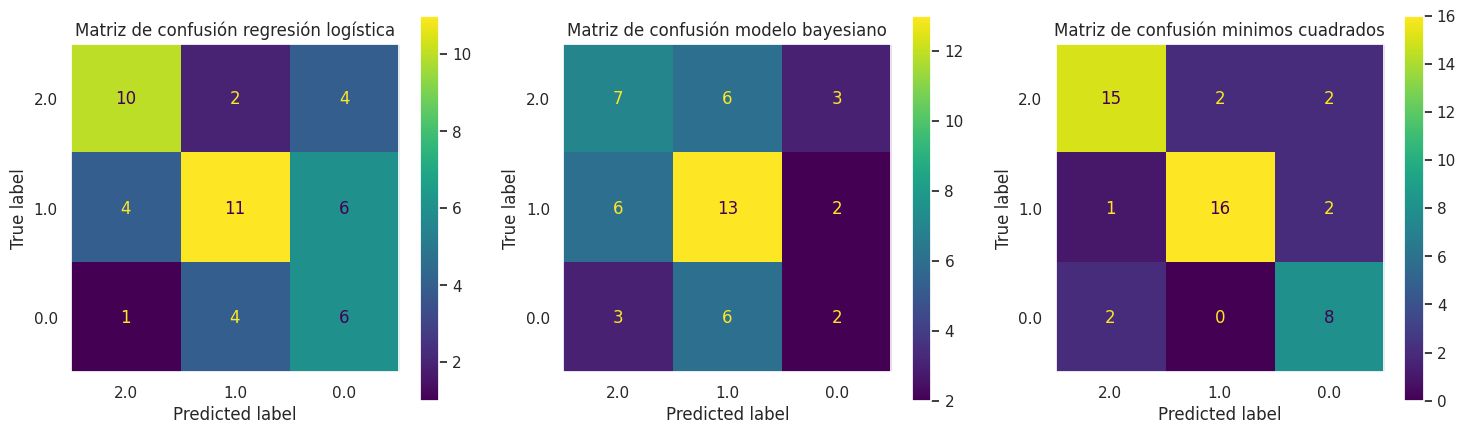

In [8]:
pca = PCA(n_components = 20)  # project from 64 to 2 dimensions
projectedZ = pca.fit_transform(X)
cMat_test_LR,cMat_test_NB,cMat_test_cu,accTest_LR,accTest_NB,accTest_mi = modelos(projectedZ,Y)
graficar(cMat_test_LR,cMat_test_NB,cMat_test_cu)
acc_LR.append(accTest_LR)
acc_NB.append(accTest_NB)
acc_mi.append(accTest_mi)

### 30 componentes

Accuracy para regresión logística:  0.5
Accuracy para modelo bayesiano:  0.3958333333333333
Accuracy para minimos cuadrados:  0.8125


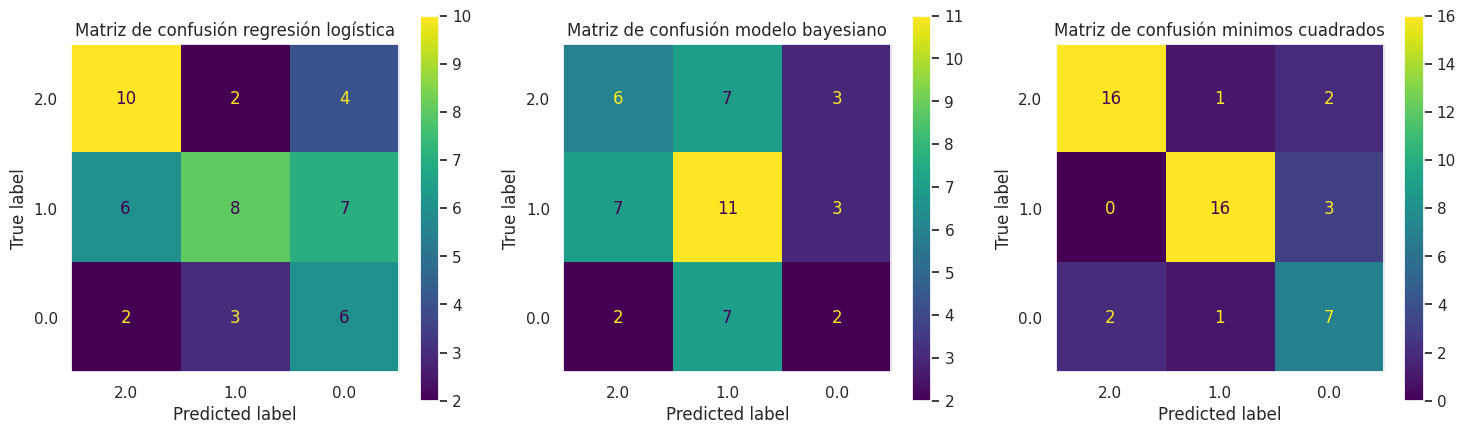

In [9]:
pca = PCA(n_components = 30)  # project from 64 to 2 dimensions
projectedZ = pca.fit_transform(X)
cMat_test_LR,cMat_test_NB,cMat_test_cu,accTest_LR,accTest_NB,accTest_mi = modelos(projectedZ,Y)
graficar(cMat_test_LR,cMat_test_NB,cMat_test_cu)
acc_LR.append(accTest_LR)
acc_NB.append(accTest_NB)
acc_mi.append(accTest_mi)

### 40 componentes

Accuracy para regresión logística:  0.5416666666666666
Accuracy para modelo bayesiano:  0.4166666666666667
Accuracy para minimos cuadrados:  0.75


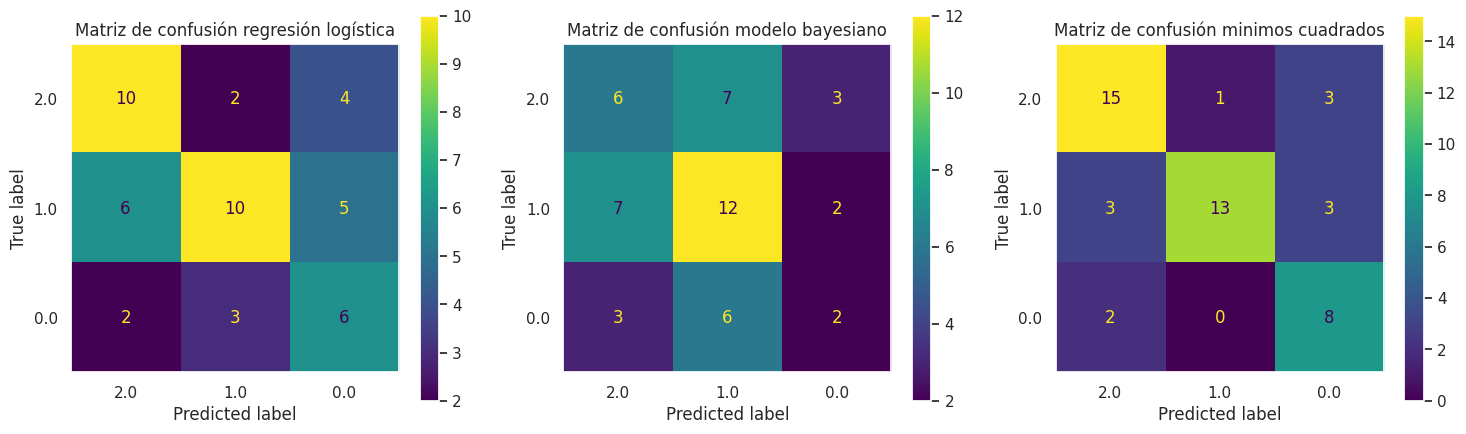

In [10]:
pca = PCA(n_components = 40)  # project from 64 to 2 dimensions
projectedZ = pca.fit_transform(X)
cMat_test_LR,cMat_test_NB,cMat_test_cu,accTest_LR,accTest_NB,accTest_mi = modelos(projectedZ,Y)
graficar(cMat_test_LR,cMat_test_NB,cMat_test_cu)
acc_LR.append(accTest_LR)
acc_NB.append(accTest_NB)
acc_mi.append(accTest_mi)

### 50 componentes

Accuracy para regresión logística:  0.5416666666666666
Accuracy para modelo bayesiano:  0.4583333333333333
Accuracy para minimos cuadrados:  0.8333333333333334


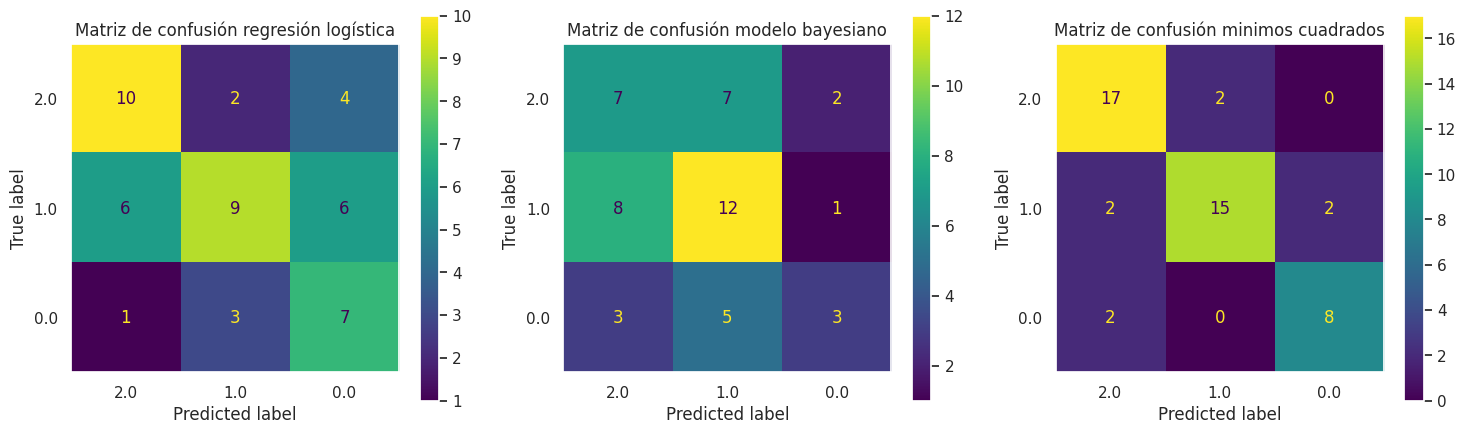

In [11]:
pca = PCA(n_components = 50)  # project from 64 to 2 dimensions
projectedZ = pca.fit_transform(X)
cMat_test_LR,cMat_test_NB,cMat_test_cu,accTest_LR,accTest_NB,accTest_mi = modelos(projectedZ,Y)
graficar(cMat_test_LR,cMat_test_NB,cMat_test_cu)
acc_LR.append(accTest_LR)
acc_NB.append(accTest_NB)
acc_mi.append(accTest_mi)

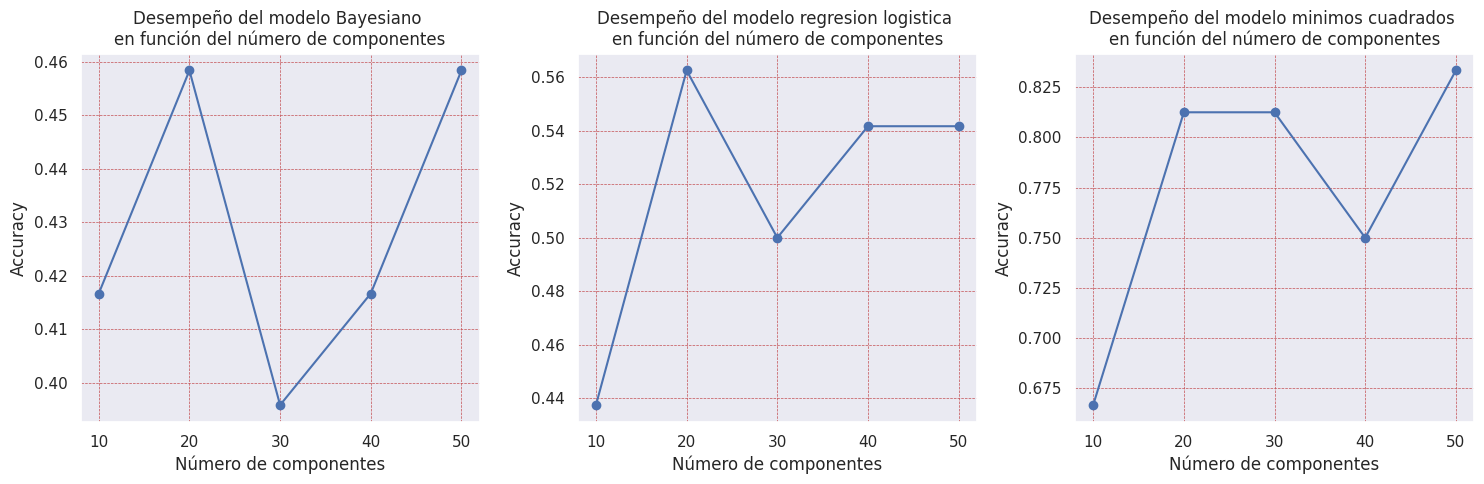

In [12]:
valores=[10,20,30,40,50]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(valores,acc_NB, marker='o')
axs[0].set_xlabel('Número de componentes')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Desempeño del modelo Bayesiano \nen función del número de componentes')
axs[0].grid(color='r', linestyle='--', linewidth=0.5)


axs[1].plot(valores, acc_LR, marker='o')
axs[1].set_xlabel('Número de componentes')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Desempeño del modelo regresion logistica \nen función del número de componentes')
axs[1].grid(color='r', linestyle='--', linewidth=0.5)

axs[2].plot(valores, acc_mi, marker='o')
axs[2].set_xlabel('Número de componentes')
axs[2].set_ylabel('Accuracy')
axs[2].set_title('Desempeño del modelo minimos cuadrados \nen función del número de componentes')
axs[2].grid(color='r', linestyle='--', linewidth=0.5)
#plt.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()


### Analisis.

- Para los resultados en los cuales no se aplicó PCA, la matriz de confusión refleja resultados coherentes, en línea con las expectativas. Esto se debe a que, al observar la gráfica de pairplots, no se evidenciaba una clara separación entre los grupos de datos. Al analizar la matriz de confusión, se concluye que el modelo de mínimos cuadrados es el que mejor se ajusta a los datos y ofrece predicciones más precisas para el análisis. Esta afirmación se respalda con el valor de precisión (accuracy) más alto registrado para el modelo de mínimos cuadrados. En contraste, el modelo bayesiano no se adapta de manera óptima a los datos, ya que sus predicciones muestran un rendimiento inferior.

- Al implementar PCA, se observa una tendencia notable en los resultados: el modelo de mínimos cuadrados destaca como el mejor en comparación con los demás modelos. Esta tendencia persiste independientemente del número de componentes implementadas para PCA; el modelo de mínimos cuadrados continúa siendo la opción que mejor se ajusta a los datos.

- La incorporación de PCA resulta altamente beneficiosa para mejorar significativamente las predicciones finales de los datos, independientemente del modelo utilizado. PCA no solo contribuye a la reducción de la dimensionalidad de los datos, sino que también favorece la generación de predicciones más precisas, acercando así los modelos a la realidad de los datos.

-
Al modificar el número de componentes en el análisis con PCA, se observa un cambio significativo en los modelos bayesiano y de mínimos cuadrados. En contraste, el modelo de regresión logística tiende a mantenerse constante con respecto al número de componentes, exhibiendo una relativa insensibilidad a estas variaciones. Para el modelo de mínimos cuadrados, se identifica un intervalo de componentes donde su rendimiento parece no ser óptimo en comparación con otros números de componentes en el mismo modelo. No obstante, al incrementar el número de componentes, se observa una mejora notable. Es importante tener presente que la elección del número de componentes debe realizarse con cautela, ya que un ajuste excesivo podría llevar al sobreajuste del modelo o generar un costo computacional elevado en el proceso.


2.Kernel PCA: Reducción de Dimensionalidad No Lineal

Dado que PCA es un modelo lineal de variable latente en el cual las características son mapeadas de la forma $z = Wx$, en muchas aplicaciones reales las relaciones entre los datos son no lineales. Es por esto que modelos como la reducción de la dimensionalidad a través del uso de funciones de mapeo (kernel) no lineales pueden ayudarnos en la tarea. Aquí, el mapeo se realiza utilizando $z = \Phi(x)$, donde $\Phi$ es la matriz de mapeo no lineal conocida como función de kernel.

Estas funciones de kernel pueden tener diferentes naturalezas como lineales, exponenciales, polinomiales, entre otras. Su objetivo aquí es realizar el procedimiento de mapeo del dataset de movimientos utilizando Kernel PCA (Kernel Principal Component Analysis).

En términos matemáticos, el proceso de mapeo no lineal se puede expresar como: $z = \Phi(x)$ Donde $z$ es la representación en un espacio de características de mayor dimensionalidad,$x$ es la entrada original, y $\Phi$ es la función de kernel.Estas funciones de kernel pueden tener diferentes naturaleza como lineales, exponenciales, polinomiales,
entre otras. Su objetivo aquí es realizar el procedimiento de mapeo del dataset de movimientos utlizando Kernel
PCA (Kernel Principal Component Análisis).

a) Cómo lucen las características proyectados en ambos espacios latentes PCA y KPCA?. Implemente su visualización.

In [ ]:
@interact(kernel= ['rbf','linear','poly','cosine'])

def kernel(kernel):
  kpca = KernelPCA(kernel=kernel, gamma=10,n_components=2)
  projectedZ2 = kpca.fit_transform(X)
  viridis_colors = [cm.viridis(x) for x in [0.1, 0.5, 0.9]]

  pca1 = PCA(n_components=2)
  projectedZ1 = pca1.fit_transform(X)

  # Configura el subplot con 1 fila y 2 columnas
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))

  # Kernel PCA
  for label in range(3):
      axes[0].scatter(
          projectedZ2[np.squeeze(y) == label, 0],
          projectedZ2[np.squeeze(y) == label, 1],
          c=[viridis_colors[label]],
          edgecolor='none',
          alpha=0.8,
          label=f'Emoción {label}'
      )

  axes[0].legend()
  axes[0].set_title('Kernel PCA')
  axes[0].set_xlabel('Componente Principal 1')
  axes[0].set_ylabel('Componente Principal 2')

  # PCA
  for label in range(3):
      axes[1].scatter(
          projectedZ1[np.squeeze(y) == label, 0],
          projectedZ1[np.squeeze(y) == label, 1],
          c=[viridis_colors[label]],
          edgecolor='none',
          alpha=0.8,
          label=f'Emoción {label}'
      )
  axes[1].legend()
  axes[1].set_title('PCA')
  axes[1].set_xlabel('Componente Principal 1')
  axes[1].set_ylabel('Componente Principal 2')

  plt.show()

interactive(children=(Dropdown(description='kernel', options=('rbf', 'linear', 'poly', 'cosine'), value='rbf')…

Para este caso se implementaron varias funciones de kernel como lo son: polinomial, lineal, base radial y coseno.

**Funcion polinomial:** en este caso se observan muy pocos puntos en la grafica, esto se puede deber a que esta funcion puede aumentar la capacidad del modelo para discriminar entre diferentes clases.

**Función lineal:** al observar esta funcion y comparando con PCA no se observa ningun cambio, las dos graficas son exactamente iguales.

**Función base radial:** : en esta funcion si se observa un cambio significativo respecto a PCA, ya que los datos se agrupan como si fueran a formar una linea recta en X=0.

**Funcion coseno:** en esta instancia, se observa como todos los datos se dispersan por toda la grafica, y si comparamos con PCA se puede observar mejor los datos, ya que en PCA al estar todos los datos agrupados no se lograban visualizar bien.

b) Utilice este nuevo subconjunto de datos con un clasificador basado en regresión Logística para el reconocimiento.
Qué puede evidenciar en el desempeño del nuevo modelo de reconocimiento (con KPCA) para esta tarea?

Accuracy para KPCA con kernel rbf: 0.3541666666666667
Accuracy para KPCA con kernel linear: 0.3541666666666667
Accuracy para KPCA con kernel poly: 0.375
Accuracy para KPCA con kernel cosine: 0.2708333333333333


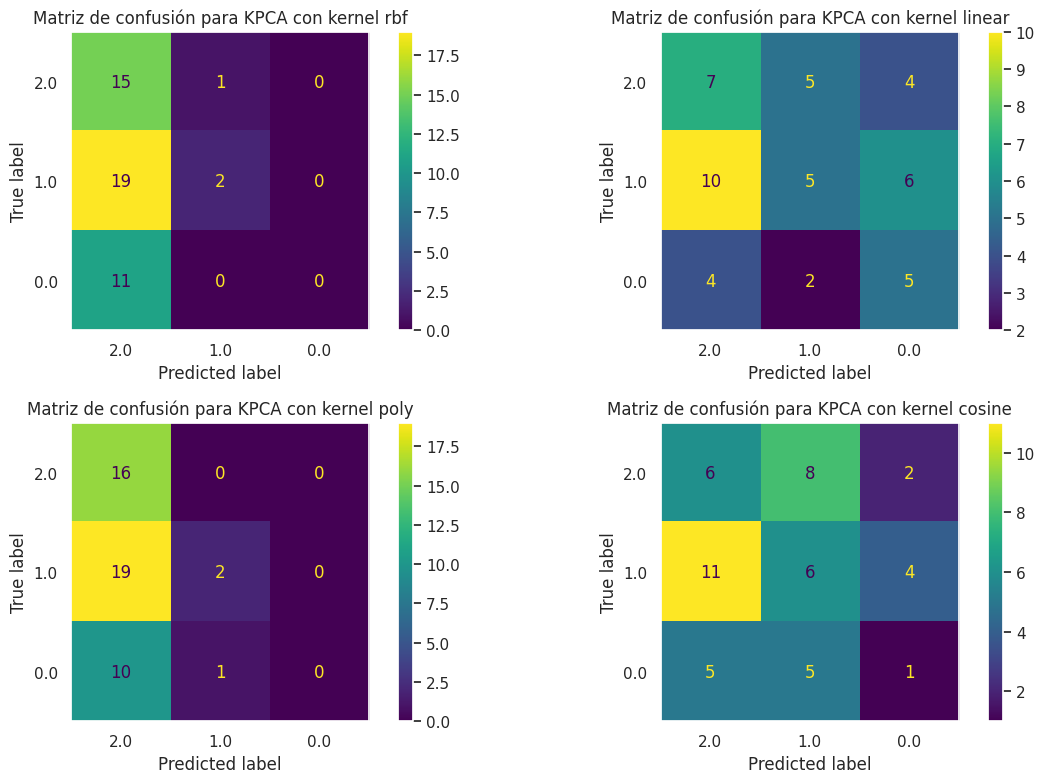

In [ ]:
kernels = ['rbf', 'linear', 'poly', 'cosine']
emociones_uniques = target.unique()

# Configurar la cuadrícula de subgráficos
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Aplanar la matriz de subgráficos para facilitar la iteración
axes = axes.flatten()
acc_LR_K=[]

for i, (ax, kernel) in enumerate(zip(axes.flatten(), kernels)):
    kpca = KernelPCA(kernel=kernel, gamma=10, n_components=2)
    projectedZ2 = kpca.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(projectedZ2, Y, test_size=0.3, random_state=0)
    y_train = y_train.ravel()
    y_test = y_test.ravel()

    # Regresión Logística
    clf = LogisticRegression(max_iter=1600).fit(X_train, y_train)
    y_pred_LR_test = clf.predict(X_test)

    # Calcular y mostrar el accuracy
    accTest_LR = accuracy_score(y_test, y_pred_LR_test)
    print(f'Accuracy para KPCA con kernel {kernel}: {accTest_LR}')
    acc_LR_K.append(accTest_LR)
    # Mostrar la matriz de confusión en el subgráfico correspondiente
    cMat_test_LR = confusion_matrix(y_test, y_pred_LR_test)
    matrix = ConfusionMatrixDisplay(cMat_test_LR, display_labels=emociones_uniques)
    matrix.plot(ax=ax)
    ax.grid(False)
    ax.set_title(f'Matriz de confusión para KPCA con kernel {kernel}')

# Ajustar el diseño y mostrar los gráficos
plt.tight_layout()
plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


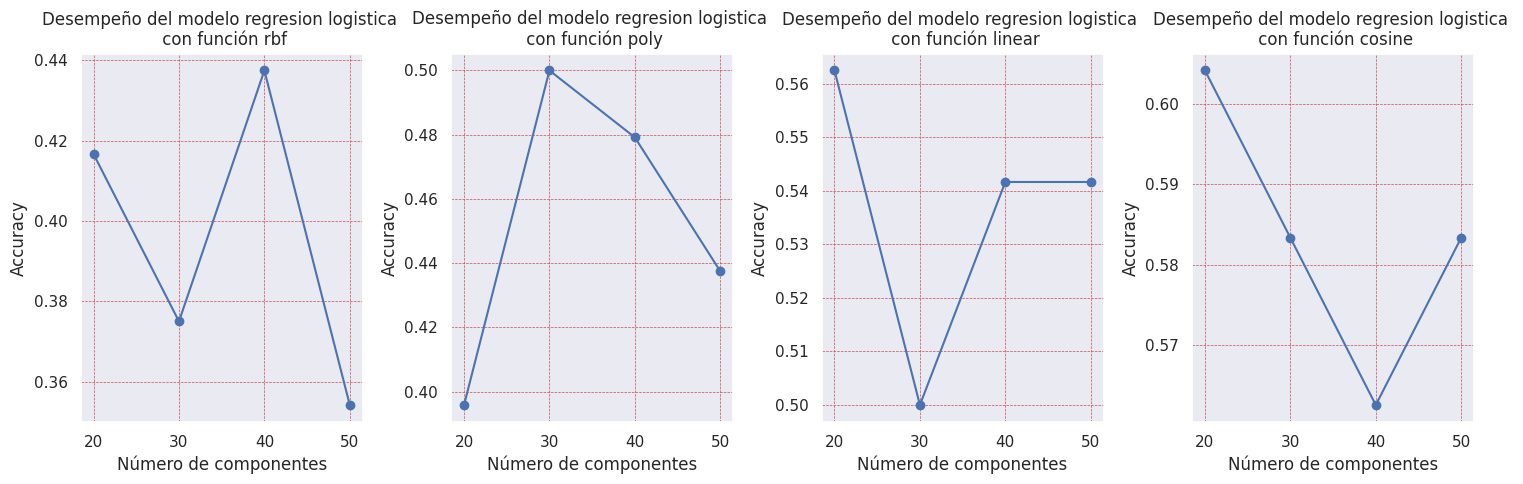

In [ ]:

valores = [20, 30, 40, 50]
kernels = ['rbf', 'poly', 'linear', 'cosine']

# Diccionario para almacenar los resultados
acc_LR_dict = {kernel: [] for kernel in kernels}

for kernel in kernels:
    acc_list = []  # Almacena las precisiones para este kernel
    for i in valores:
        # Configuración del KernelPCA
        kpca = KernelPCA(kernel=kernel, gamma=10, n_components=i)
        projectedZ2 = kpca.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(projectedZ2, Y, test_size=0.3, random_state=0)
        y_train = y_train.ravel()
        y_test = y_test.ravel()

        # Regresión Logística
        clf = LogisticRegression(max_iter=20000).fit(X_train, y_train)
        y_pred_LR = clf.predict(X_test)

        # Calcular y almacenar el accuracy
        accTest_LR = accuracy_score(y_test, y_pred_LR)
        acc_list.append(accTest_LR)

    # Almacenar la lista de precisiones para este kernel en el diccionario
    acc_LR_dict[kernel] = acc_list

# Gráficas
fig, axs = plt.subplots(1, len(kernels), figsize=(15, 5))

for i, kernel in enumerate(kernels):
    axs[i].plot(valores, acc_LR_dict[kernel], marker='o')
    axs[i].set_xlabel('Número de componentes')
    axs[i].set_ylabel('Accuracy')
    axs[i].set_title(f'Desempeño del modelo regresion logistica \n con función {kernel}')
    axs[i].grid(color='r', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
